## Import the necessary software libraries:

In [ ]:
# !pip install 'gym[box2d]'
# !apt-get install python-opengl -y
# !apt install xvfb -y
# !pip install pyvirtualdisplay
# !pip install https://github.com/pyglet/pyglet/archive/pyglet-1.5-maintenance.zip
# !apt-get install ffmpeg -y
# !pip install torch==1.6

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0,size=(600,600))
display.start()

In [3]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

from utils import test_policy_network, seed_everything, plot_stats
from parallel_env import ParallelEnv, ParallelWrapper

## Create and preprocess the environment

### Create the environment

In [4]:
env =gym.make("Acrobot-v1")

In [5]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: 6. Actions: 3
Sample state: [ 0.99995509  0.00947691  0.99655795  0.08289904 -0.09657197 -0.09981141]


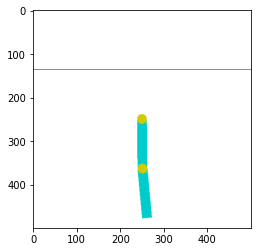

In [6]:
plt.imshow(env.render(mode='rgb_array'))

### Parallelize the environment

In [7]:
num_envs = os.cpu_count()

In [8]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env, seed=seed)
    return env

In [9]:
env_fns = [lambda : create_env('Acrobot-v1', rank) for rank in range(num_envs)]
parallel_env = ParallelEnv(env_fns)

### Prepare the environment to work with PyTorch

In [10]:
class PreprocessEnv(ParallelWrapper):
    
    def __init__(self, env):
        ParallelWrapper.__init__(self, env)
    
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
    
    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
     
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [11]:
parallel_env = PreprocessEnv(parallel_env)

### Create the policy $\pi(s)$

In [12]:
policy = nn.Sequential(
    nn.Linear(dims, 128), 
    nn.ReLU(),
    nn.Linear(128, 64), 
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1)
)

### Create the value network $v(s)$

In [13]:
value_net = nn.Sequential(
    nn.Linear(dims, 128), 
    nn.ReLU(),
    nn.Linear(128, 64), 
    nn.ReLU(),
    nn.Linear(64, 1),
)

## Implement the algorithm

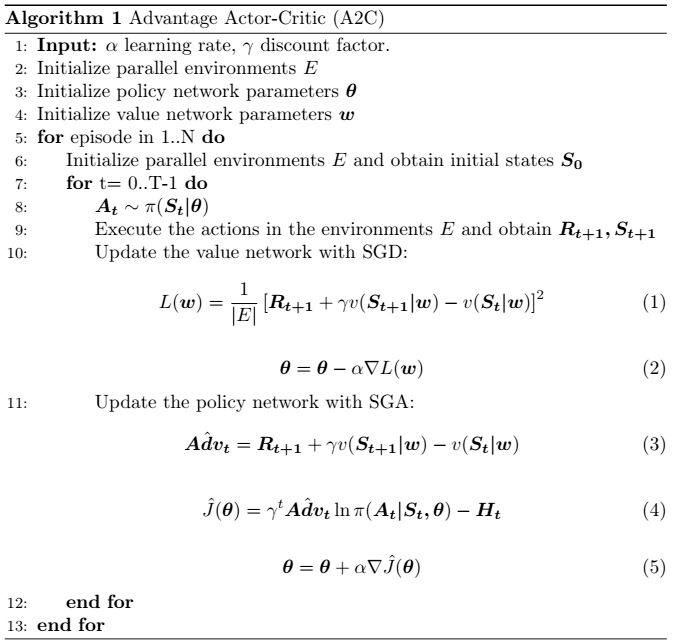

In [15]:
def action_critic(policy, value_net, episodes, alpha=1e-4, gamma=0.99):
    policy_optim = AdamW(policy.parameters(), lr=alpha)
    value_optim = AdamW(value_net.parameters(), lr=alpha)

    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    for episode in tqdm(range(1, episodes+1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs,1), dtype=torch.bool)
        ep_return = torch.zeros((num_envs,1))
        I = 1.

        while not done_b.all():
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)

            value = value_net(state)
            target = reward + ~done * gamma * value_net(next_state).detach()
            critic_loss = F.mse_loss(value, target)
            value_net.zero_grad()
            critic_loss.backward()
            value_optim.step()

            advantage = (target - value).detach()
            probs = policy(state)
            
            log_probs = torch.log(probs + 1e-6)
            
            action_log_prob = log_probs.gather(1,action)
            entropy = -torch.sum(probs * log_probs, dim=-1, keepdim=True)

            actor_loss = -I * action_log_prob * advantage - 0.01 * entropy
            actor_loss = actor_loss.mean()

            policy.zero_grad()
            actor_loss.backward()
            policy_optim.step()

            ep_return += reward
            done_b |= done
            state = next_state
            I = I * gamma

        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return.mean().item())
    
    return stats

In [16]:
stats = action_critic(policy, value_net, 500, alpha=1e-4, gamma=0.99)

100%|██████████| 500/500 [03:57<00:00,  2.11it/s]


## Show results

### Show execution stats

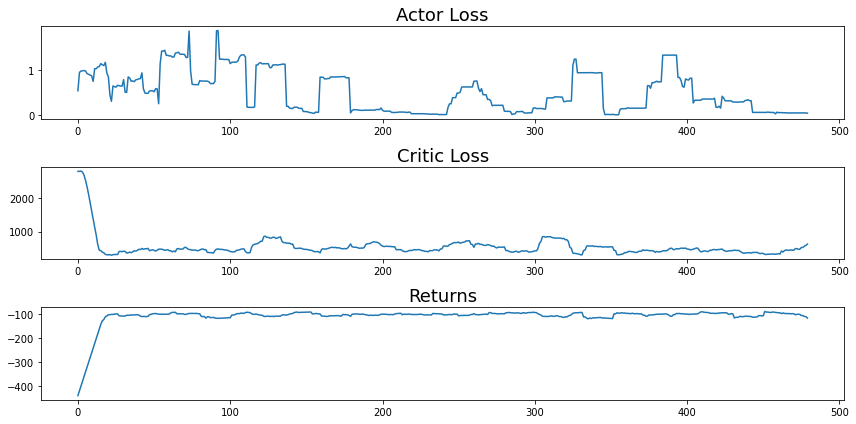

In [17]:
plot_stats(stats)

### Test the resulting agent

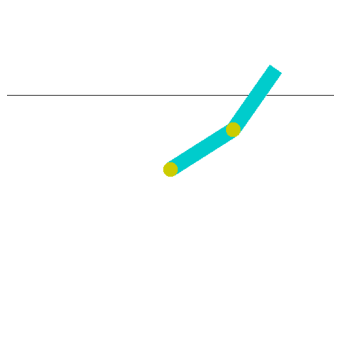

In [18]:
test_policy_network(env, policy, episodes=2)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)